# Aim
To predict the location of the heart on chest X-ray images using bounding box.
The task is carried out using Pytorch in a Jupyter Notebook. Transfer Learning approach is used with a ResNet18 model

# Dataset Description

The datasets comprise 500 images from the RSNA pneumonia detection challenge dataset. This is similar data to those I have used in predicting pneumonia in x-ray images


# Data preparation and libraries import
I have done the following to prepare the data:

1. Extracted the images from DICOM files
2. Inspected the labels in a dataframe
3. Visualized the images and bounding box around the heart


In [3]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imgaug
from imgaug.augmentables.bbs import BoundingBox
import pandas as pd
import torch, torchvision
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [4]:
#from pathlib import Path
#print(Path.cwd())

#### Import the labels of the dataset into a dataframe

In [4]:
labels = pd.read_csv("rsna_heart_detection.csv")
labels.head(6)

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224
5,heart,63,60,100,85,f1e96436-85c2-4179-b7e9-3f3091e29d76,224,224


#### Retrive some dicome images and plot them with bounding boxes

In [5]:
#Path to the trainig images
ROOT_PATH = Path(r'C:\Users\Owner\OneDrive - University of Eastern Finland\Desktop\DL\AI-IN-MEDICAL-MATERIALS_NEW\AI-IN-MEDICAL-MATERIALS\04-Pneumonia-Classification\stage_2_train_images')
#Path to the save the processes trainig images
SAVE_PATH = Path('Processed-Heart-Detection/')

In [7]:
data = labels.iloc[1]
patient_id = data['name'] # Get the c-th row of the labels
          
     # Create the path to the dcm file and add dcm to the file
image_path = ROOT_PATH/f'{patient_id}.dcm'

image_path

WindowsPath('C:/Users/Owner/OneDrive - University of Eastern Finland/Desktop/DL/AI-IN-MEDICAL-MATERIALS_NEW/AI-IN-MEDICAL-MATERIALS/04-Pneumonia-Classification/stage_2_train_images/e5f292ae-f1e5-497c-b0a0-68f1aa2196b2.dcm')

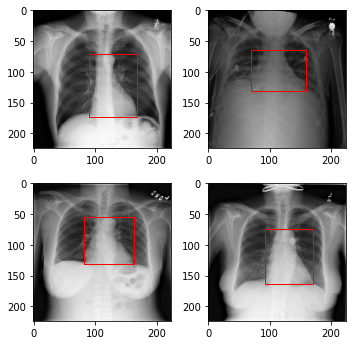

In [8]:
fig, axis = plt.subplots(2, 2, figsize=(5, 5))

c=0

for i in range(2):
    for j in range(2):
        data = labels.iloc[c]
        patient_id = data['name'] # Get the c-th row of the labels
          
     # Create the path to the dcm file and add dcm to the file
        image_path = ROOT_PATH/f'{patient_id}.dcm'
     # Alternative way to do this:  ROOT_PATH/str(patient_id).with_suffix('.dcm')

        img = pydicom.dcmread(image_path)# Read the dicom file with pydicom

    # Retrieve the actual image and resize it to match the labels
        img = img.pixel_array
        img = cv2.resize(img, (224, 224))

        # Cerating variables to be used for box corners
        x = data['x0']
        y = data['y0']
        width = data['w']
        height = data['h']

        axis[i][j].imshow(img, cmap='gray')
        axis[i][j].add_patch(patches.Rectangle((x, y), width, height, edgecolor='r', fill=False))
        
        c+=1
    plt.tight_layout()

# Data Preprocessing 

The following would be done:

1. Standardize the image to 0 - 1 range
2. Normalizing the images
3. Resize the images
4. Seperating data into test and train group and save in folders

In [11]:
# Initialize variables to compute mean and mean squared pixel values for normalization
sums, sums_squared = 0, 0

train_ids = []
val_ids = []

# Iterate over all patient IDs in the dataset
for counter, patient_id in enumerate(list(labels['name'])):
    image_path = ROOT_PATH / f'{patient_id}.dcm'
    img = pydicom.dcmread(image_path)
    
    # Extract the image array and standardize the pixel values to [0, 1]
    img = img.pixel_array
    img = img/255.0

    # Resize the image to 224x224 for model input compatibility and efficiency
    img = cv2.resize(img, (224, 224)).astype(np.float16)

    # Split into training (first 400 samples) and validation (remaining)
    train_or_val = 'train' if counter < 400 else 'val'

    # Store the patient ID in a list
    if train_or_val == "train":
        train_ids.append(patient_id)
    else:
        val_ids.append(patient_id)

    # Define the path for saving the processed image
    current_save_path = SAVE_PATH/train_or_val
    current_save_path.mkdir(parents=True, exist_ok=True)

    # Save the preprocessed image as NumPy files using the patient ID as the filename
    np.save(current_save_path/patient_id, img)  

    # Compute per-image mean and squared mean (for normalization statistics)
    # Note: Only training images should be included in statistics
    if train_or_val == 'Train':
        normalizer = img.shape[0] * img.shape[1]
        sums += np.sum(img) / normalizer
        sums_squared += np.sum(img ** 2) / normalizer

#### Save the train and val subject IDs in a file.

In [12]:
base_path = Path("C:/Users/Owner/OneDrive - University of Eastern Finland/Desktop/DL/AI-IN-MEDICAL-MATERIALS_NEW/AI-IN-MEDICAL-MATERIALS/05-Detection/Processed-Heart-Detection")
np.save(base_path / "train_subjects_det.npy", train_ids)
np.save(base_path / "val_subjects_det.npy", val_ids)

#### Compute per-image mean and standard deviation of the entire dataset

In [13]:
mean = sums / len(train_ids)
std = np.sqrt(sums_squared / len(train_ids) - (mean**2), dtype=np.float64)
print(f"Mean of Dataset: {mean}, STD: {std}")

Mean of Dataset: 0.0, STD: 0.0


# Dataset class for training.
This would augment the x-ray image and corresponding dataset.

The class returns an augmented image and bounding box cordinate around the heart to be fed in the training model

In [14]:
class CardiacDataset(torch.utils.data.Dataset):

  def __init__(self, path_to_labels_csv, patients, root_path, augs):
    self.labels = pd.read_csv(path_to_labels_csv)
    self.patients = np.load(patients)
    self.root_path = Path(root_path)
    self.augument = augs

  def __len__(self):
    return len(self.patients)


  def __getitem__(self, idx):
    patient = self.patients[idx]

    data = self.labels[self.labels['name'] == patient]

    # Check if data for the patient exists
    if data.empty:
        print(f"Warning: No label data found for patient {patient}. Skipping.")
        return None # Return None if no label data

    x_min = data["x0"].item()
    y_min = data["y0"].item()
    x_max = x_min + data["w"].item()  # get xmax from width
    y_max = y_min + data["h"].item()  # get ymax from height
    bbox = [x_min, y_min, x_max, y_max]

    file_path = self.root_path/patient
    # Add error handling for file loading
    try:
        img = np.load(f'{file_path}.npy').astype(np.float32)
    except FileNotFoundError:
        print(f"Warning: Image file not found for patient {patient} at {file_path}. Skipping.")
        return None # Return None if image file not found
    except Exception as e:
        print(f"Warning: Error loading image for patient {patient}: {e}. Skipping.")
        return None # Return None for other loading errors


    if self.augument:
      bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
      random_seed = torch.randint(0, 1000000, (1,)).item()
      imgaug.seed(random_seed)

      # imgaug expects image to be of shape (H, W) or (H, W, C)
      # Convert the image to the expected shape if it's currently (1, H, W)
      if img.ndim == 3 and img.shape[0] == 1:
          img_aug_input = img.squeeze(0)
      else:
          img_aug_input = img

      try:
          img_augmented, aug_bbox  = self.augument(image=img_aug_input, bounding_boxes=bb)
          # imgaug returns (H, W) or (H, W, C), convert back to (1, H, W) if necessary
          if img.ndim == 3 and img.shape[0] == 1:
               img = torch.tensor(img_augmented).unsqueeze(0)
          else:
               img = torch.tensor(img_augmented)

          # Convert the augmented bounding box back to the desired format [x_min, y_min, x_max, y_max]
          bbox = [aug_bbox.x1, aug_bbox.y1, aug_bbox.x2, aug_bbox.y2]

      except Exception as e:
          print(f"Warning: Error during augmentation for patient {patient}: {e}. Skipping.")
          return None


    # Normalize the image according to the values computed in Preprocessing
    # Ensure img is a tensor before normalization
    if not isinstance(img, torch.Tensor):
        img = torch.tensor(img)

    img = (img - 0.494) / 0.252

    # Ensure image has a channel dimension if it doesn't already
    if img.ndim == 2:
         img = img.unsqueeze(0)

    bbox = torch.tensor(bbox)

    return img, bbox

#### Testing the data augmentation method

In [15]:
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.patches as patches

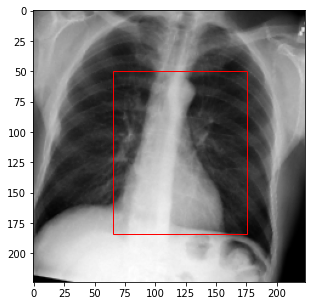

In [18]:
# First create the augmentation object

seq = iaa.Sequential([
          iaa.GammaContrast(),
          iaa.Affine(
          scale=(0.8, 1.2),
          rotate=(-10, 10),
          translate_px = (-10, 10)
          )
])

# Creating the dataset objects 
base_path2 = Path("C:/Users/Owner/OneDrive - University of Eastern Finland/Desktop/DL/AI-IN-MEDICAL-MATERIALS_NEW/AI-IN-MEDICAL-MATERIALS/05-Detection")
label_path =  base_path2 / "rsna_heart_detection.csv"
patient_path =  base_path2 / "Processed-Heart-Detection/train_subjects_det.npy"
root_path = base_path2 / "Processed-Heart-Detection/train/"
dataset = CardiacDataset(label_path, patient_path, root_path, seq)


img, bbox = dataset[0]
fig, axis = plt.subplots(1, 1, figsize=(5, 5))
axis.imshow(img[0], cmap='gray')
axis.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor='r', fill=False))


## Creating the dataset to be fed into the model

First the data augmentation pipeline is created and next the train and validation dataloaders are created.

In [22]:
base_path2 = Path("C:/Users/Owner/OneDrive - University of Eastern Finland/Desktop/DL/AI-IN-MEDICAL-MATERIALS_NEW/AI-IN-MEDICAL-MATERIALS/05-Detection")

data_labels = base_path2 / 'rsna_heart_detection.csv'
train_root_path = base_path2/ 'Processed-Heart-Detection/train/'
train_subjects = base_path2/ 'Processed-Heart-Detection/train_subjects_det.npy'
val_root_path = base_path2/ 'Processed-Heart-Detection/val/'
val_subjects = base_path2/ 'Processed-Heart-Detection/val_subjects_det.npy'

seq = iaa.Sequential([
          iaa.GammaContrast(),
          iaa.Affine(
          scale=(0.8, 1.2),
          rotate=(-10, 10),
          translate_px = (-10, 10)
          )
])


train_dataset = CardiacDataset(
     data_labels,
     train_subjects,
     train_root_path,
     augs = seq)


val_dataset = CardiacDataset(
     data_labels,
     val_subjects,
     val_root_path,
     augs = None)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 400 train images and 96 val images


In [23]:
batch_size = 5
numworkers = 0

train_loader = torch.utils.data.DataLoader(train_dataset, num_workers = numworkers, batch_size = batch_size, shuffle = True)
val_loader  = torch.utils.data.DataLoader(val_dataset, num_workers = numworkers, batch_size = batch_size, shuffle = False)

# Cardiac detection model

Transfer learning is used in accomplishing this task


In [27]:
class CardiacDetectionModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = torchvision.models.resnet18(pretrained=True)
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # Change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 4
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.MSELoss()

    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  #Convert label to float (just needed for loss computation)
        pred = self(x_ray)
        loss = self.loss_fn(pred, label)  #Compute the loss

        # Log loss
        self.log("Train Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Train")

        return loss


    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label

        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)

        loss = self.loss_fn(pred, label)
        self.log("Val Loss", loss)
        if batch_idx % 50 == 0:
            self.log_images(x_ray.cpu(), pred.cpu(), label.cpu(), "Val")
        return loss

    def log_images(self, x_ray, pred, label, name):
        results = []

        # Here we create a grid consisting of 4 predictions
        for i in range(4):
            coords_labels = label[i]
            coords_pred = pred[i]
            img = ((x_ray[i] * 0.252)+0.494).numpy()[0]

            # Extract the coordinates from the label
            x0, y0 = coords_labels[0].int().item(), coords_labels[1].int().item()
            x1, y1 = coords_labels[2].int().item(), coords_labels[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (0, 0, 0), 2)

            # Extract the coordinates from the prediction
            x0, y0 = coords_pred[0].int().item(), coords_pred[1].int().item()
            x1, y1 = coords_pred[2].int().item(), coords_pred[3].int().item()
            img = cv2.rectangle(img, (x0, y0), (x1, y1), (1, 1, 1), 2)


            results.append(torch.tensor(img).unsqueeze(0))
        grid = torchvision.utils.make_grid(results, 2)
        self.logger.experiment.add_image(f"{name} Prediction vs Label", grid, self.global_step)



    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]


In [100]:
#Instanciate the model
model = CardiacDetectionModel()  

In [101]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss',
    save_top_k=10,
    mode='min')

In [102]:
# Create the trainer
# Change the gpus parameter to the number of available gpus in your computer. Use 0 for CPU training

trainer = pl.Trainer(accelerator='cpu', logger=TensorBoardLogger("./logs"), log_every_n_steps=1,
                     default_root_dir="./weights", callbacks=checkpoint_callback,
                     max_epochs=100)



GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [103]:
# Train the detection model
trainer.fit(model, train_loader, val_loader)


  | Name    | Type    | Params
------------------------------------
0 | model   | ResNet  | 11.2 M
1 | loss_fn | MSELoss | 0     
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.689    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\Owner\anaconda3\envs\pytorchenv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\Owner\anaconda3\envs\pytorchenv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:03, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [1]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_from_checkpoint("weight.ckpt")
model.eval()
model.to(device)

NameError: name 'torch' is not defined

## Evaluating the model

In [ ]:
preds = []
labels = []

with torch.no_grad():
    for data, label in val_dataset:
        data = data.to(device).float().unsqueeze(0)
        pred = model(data)[0].cpu()
        preds.append(pred)
        labels.append(label)
        
preds = torch.stack(preds)
labels = torch.stack(labels)

In [ ]:
abs(preds - labels).mean(0)

## Example of a prediction

In [ ]:
IDX = 75
img, label = val_dataset[IDX]
current_pred = preds[IDX]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap = 'bone')
heart = patches.Rectangle((current_pred[0], current_pred[1]), current_pred[2]-current_pred[0],
                          current_pred[3]-current_pred[1], linewidth=1, edgecolor='r', facecolor='none')

axis.add_patch(heart)

print(label)